In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

## Initialization

### Imports

In [2]:
import os
import sys
import torch
import zipfile
import numpy as np
import pandas as pd
import plotly.express as px

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

sys.path.append("../code/")

In [3]:
from params import *

from data.transforms import HE_preprocess
from data.dataset import TileDataset

from model_zoo.models import define_model

from training.main import k_fold
from utils.logger import (
    prepare_log_folder,
    save_config,
    create_logger,
    update_overall_logs,
)

### Load

In [4]:
df_info = pd.read_csv(DATA_PATH + f"HuBMAP-20-dataset_information.csv")
df_mask = pd.read_csv(DATA_PATH + "train.csv")
df = pd.read_csv(OUT_PATH + "df_images.csv")

## Data

In [5]:
viz_ds = TileDataset(
    df,
    IMG_PATH,
    MASK_PATH,
    transforms=HE_preprocess(augment=True, visualize=True),
)

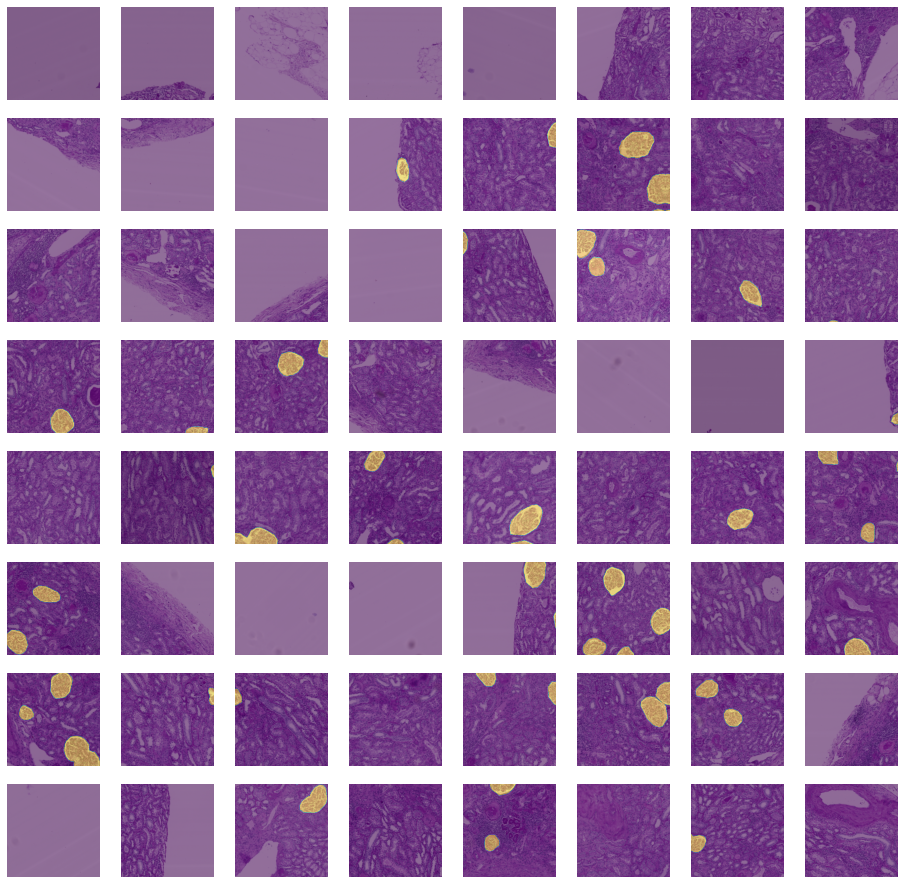

In [6]:
viz_dl = DataLoader(viz_ds, batch_size=64, shuffle=False)
imgs, masks = next(iter(viz_dl))

plt.figure(figsize=(16, 16))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    img = img.permute(1, 2, 0).numpy()  # .astype(np.uint8)
    plt.subplot(8, 8, i + 1)
    plt.imshow(img)  # , vmin=0, vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.5)
    plt.axis("off")
    plt.subplots_adjust(wspace=None, hspace=None)

## Model

In [7]:
from training.lovasz import *

In [8]:
dataset = TileDataset(
    df,
    IMG_PATH,
    MASK_PATH,
    transforms=HE_preprocess(augment=True, visualize=False),
)

In [9]:
model = define_model("Unet", "resnet18")

In [10]:
img, y = dataset[0]

In [11]:
pred = model(img.unsqueeze(0))

In [12]:
symmetric_lovasz(pred, y.unsqueeze(0))

tensor([4.9615], grad_fn=<DivBackward0>)

## Training

In [13]:
class Config:
    """
    Parameters used for training
    """

    # General
    seed = 42
    verbose = 1
    img_dir = IMG_PATH
    mask_dir = MASK_PATH
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    cv_column = "4fold"
    random_state = 0
    selected_folds = [0]  # [0, 1, 2, 3]

    # Model
    encoder = "efficientnet-b3"  # resnext50_32x4d, "resnet18", "se_resnext50_32x4d"
    decoder = "Unet"  # "Unet", "DeepLabV3Plus"
    encoder_weights = "imagenet"
    num_classes = 1

    # Training
    loss = "BCEWithLogitsLoss"  # "SoftDiceLoss" / "BCEWithLogitsLoss"  / "lovasz"
    activation = "none" if loss == "lovasz" else "sigmoid"

    optimizer = "Adam"
    batch_size = 32
    epochs = 40
    swa_first_epoch = 40

    lr = 1e-3  # 5e-4 / 1e-3
    warmup_prop = 0.05
    val_bs = 32

    first_epoch_eval = 0

    # Inference
    overlap_factor = 2

In [14]:
DEBUG = False
log_folder = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    config_df = save_config(Config, log_folder + "config.json")
    df.to_csv(log_folder + "data.csv", index=False)
    create_logger(directory=log_folder, name="logs.txt")

metrics = k_fold(Config, df, log_folder=log_folder)

Logging results to ../logs/2020-12-22/4/

-------------   Fold 1 / 4  -------------

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /home/theo/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth



    -> 3482 training images
    -> 489 validation images
    -> 13159033 trainable parameters

Epoch 01/40 	 lr=5.0e-04	 t=42s	loss=0.618	val_loss=0.294 	 dice=0.4503
Epoch 02/40 	 lr=1.0e-03	 t=40s	loss=0.139	val_loss=0.108 	 dice=0.7020
Epoch 03/40 	 lr=9.7e-04	 t=41s	loss=0.051	val_loss=0.036 	 dice=0.7581
Epoch 04/40 	 lr=9.5e-04	 t=40s	loss=0.036	val_loss=0.039 	 dice=0.7973
Epoch 05/40 	 lr=9.2e-04	 t=41s	loss=0.030	val_loss=0.024 	 dice=0.8783
Epoch 06/40 	 lr=8.9e-04	 t=40s	loss=0.026	val_loss=0.020 	 dice=0.8881
Epoch 07/40 	 lr=8.7e-04	 t=40s	loss=0.024	val_loss=0.021 	 dice=0.8638
Epoch 08/40 	 lr=8.4e-04	 t=40s	loss=0.024	val_loss=0.018 	 dice=0.8715
Epoch 09/40 	 lr=8.2e-04	 t=40s	loss=0.023	val_loss=0.019 	 dice=0.8692
Epoch 10/40 	 lr=7.9e-04	 t=40s	loss=0.021	val_loss=0.018 	 dice=0.8865
Epoch 11/40 	 lr=7.6e-04	 t=40s	loss=0.021	val_loss=0.018 	 dice=0.8952
Epoch 12/40 	 lr=7.4e-04	 t=40s	loss=0.020	val_loss=0.017 	 dice=0.8962
Epoch 13/40 	 lr=7.1e-04	 t=40s	loss=0.0